In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

* [Medium: Collaborative Filtering based Recommendation Systems exemplified..](https://towardsdatascience.com/collaborative-filtering-based-recommendation-systems-exemplified-ecbffe1c20b1)
* This notebook is a fork of: [CF Recommendation System-Examples.ipynb](https://github.com/csaluja/JupyterNotebooks-Medium/blob/master/CF%20Recommendation%20System-Examples.ipynb)

# Collaborative filtering based recommendation systems examples

Make necesarry imports

In [2]:
import sys
sys.path.append('./src')

from IPython.display import Image

import numpy as np
import pandas as pd

from scipy.spatial.distance import correlation, cosine

from ratings_matrix import RatingsMatrix

from similarity import cosine_sim, \
                       pearson_sim, \
                       spearman_sim, \
                       adjusted_cosine_sim, \
                       spearman

from predictor import UserBasedPredictor, \
                      ItemBasedPredictor, \
                      AdjustedCosineItemBasedPredictor, \
                      PredictorFactory, \
                      predict, \
                      evaluate

from similarity import CommonSimilarityService, \
                       AdjustedCosineSimilarityService

from show import show_similar_items, \
                 show_similar_users, \
                 show_prediction

from sequence import Sequence

## Ratings Matrix

* Ratings matrix is user-item ratings matrix where ratings are integers from 1-10.
* 6 users (rows) have rated 6 items (columns).

In [58]:
rm = RatingsMatrix([
    [3, 7, 4, 9,  9, 7], 
    [7, 0, 5, 3,  8, 8],
    [7, 5, 5, 0,  8, 4],
    [5, 6, 8, 5,  9, 8],
    [5, 8, 8, 8, 10, 9],
    [7, 7, 0, 4,  7, 8]
])
rm

,0,1,2,3,4,5
0,3,7,4,9,9,7
1,7,0,5,3,8,8
2,7,5,5,0,8,4
3,5,6,8,5,9,8
4,5,8,8,8,10,9
5,7,7,0,4,7,8


In [4]:
rm.shape

(6, 6)

User ratings / row values:

In [5]:
rm.row(1)

array([[3, 7, 4, 9, 9, 7]])

Mean user rating / row mean:

In [6]:
rm.mean_row(1)

6.5

User(row) rating deviation:

In [7]:
rm.row_deviation(1, 1)

-3.5

User(Row)-item(Column) rating:

In [8]:
rm.cell(3, 4)

0

Iterate each matrix value(rating):

In [9]:
[f'rating: {r}, user_id: {u_id}, item_id: {i_id}' for r, u_id, i_id in rm.cells][:10]

['rating: 3, user_id: 1, item_id: 1',
 'rating: 7, user_id: 1, item_id: 2',
 'rating: 4, user_id: 1, item_id: 3',
 'rating: 9, user_id: 1, item_id: 4',
 'rating: 9, user_id: 1, item_id: 5',
 'rating: 7, user_id: 1, item_id: 6',
 'rating: 7, user_id: 2, item_id: 1',
 'rating: 0, user_id: 2, item_id: 2',
 'rating: 5, user_id: 2, item_id: 3',
 'rating: 3, user_id: 2, item_id: 4']

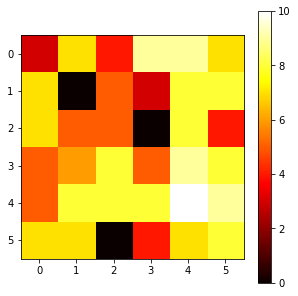

In [61]:
rm.plot()

## See similarity values

In [11]:
cosine_sim(rm)

,0,1,2,3,4,5
0,1.000000,0.799268,0.779227,0.934622,0.973890,0.884600
1,0.799268,1.000000,0.874744,0.905850,0.866146,0.827036
2,0.779227,0.874744,1.000000,0.909513,0.865454,0.853275
3,0.934622,0.905850,0.909513,1.000000,0.989344,0.865614
4,0.973890,0.866146,0.865454,0.989344,1.000000,0.881640
5,0.884600,0.827036,0.853275,0.865614,0.881640,1.000000


In [12]:
adjusted_cosine_sim(rm)

,0,1,2,3,4,5
0,1.000000,0.236908,0.421263,-0.519085,-0.125892,0.010090
1,0.236908,1.000000,-0.805243,0.085741,0.237273,0.520625
2,0.421263,-0.805243,1.000000,-0.767941,-0.230521,-0.053640
3,-0.519085,0.085741,-0.767941,1.000000,-0.299059,-0.644550
4,-0.125892,0.237273,-0.230521,-0.299059,1.000000,0.599158
5,0.010090,0.520625,-0.053640,-0.644550,0.599158,1.000000


In [13]:
pearson_sim(rm)

,0,1,2,3,4,5
0,1.000000,-0.137446,-0.357398,0.208179,0.761905,0.277350
1,-0.137446,1.000000,0.453897,0.515910,0.112456,0.218328
2,-0.357398,0.453897,1.000000,0.451378,-0.042888,0.297373
3,0.208179,0.515910,0.451378,1.000000,0.763325,-0.057739
4,0.761905,0.112456,-0.042888,0.763325,1.000000,0.039621
5,0.277350,0.218328,0.297373,-0.057739,0.039621,1.000000


## User-based

In [14]:
n_neighbors = 4

### Similar users

**CommonSimilarityService** class finds k similar users given the user_id and ratings matrix.

Using cosine similarity:

In [15]:
user_id = 1

sim_service = CommonSimilarityService(rm, cosine, n_neighbors)

similarities, indices = sim_service.similars(user_id)

show_similar_users(indices, similarities, user_id)

4 most similar users to user 1:

- User ID 5, with similarity of 0.9738899354018394.
- User ID 4, with similarity of 0.9346216841783769.
- User ID 6, with similarity of 0.8846004572297814.
- User ID 2, with similarity of 0.7992679780524188.


Using pearson similarity:

In [16]:
sim_service = CommonSimilarityService(rm, correlation, n_neighbors)

similarities, indices = sim_service.similars(user_id)

show_similar_users(indices, similarities, user_id)

4 most similar users to user 1:

- User ID 5, with similarity of 0.7619047619047619.
- User ID 6, with similarity of 0.2773500981126146.
- User ID 4, with similarity of 0.20817945092665135.
- User ID 2, with similarity of -0.13744632051327743.


### user_based_rating_predict

**UserBasedPredictor** class predicts rating for specified user-item combination based on user-based approach.

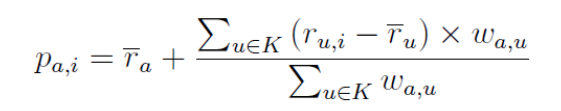

In [17]:
Image(filename='./images/user-based-similarity.png')

In [18]:
predictor = UserBasedPredictor(rm, cosine, n_neighbors)
predictor.evaluate(rm)

{'rmse': 1.701, 'mse': 2.892}

In [19]:
user_id = 3
item_id = 4

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 3.
- Item ID: 4.
- Predicted rating: 3.0.
- Real rating: 0 (0 == unrated item).


In [20]:
user_id = 1
item_id = 5

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 1.
- Item ID: 5.
- Predicted rating: 9.0.
- Real rating: 9 (0 == unrated item).


## Item-based

### Similar items (Cosine sim)

**CommonSimilarityService** class finds k similar items given the item_id and a transposed version of ratings matrix.

In [21]:
item_id = 3

sim_service = CommonSimilarityService(rm.T(), cosine, n_neighbors)

similarities, indices = sim_service.similars(item_id)

show_similar_items(indices, similarities, item_id)

4 most similar items to item 3:

- Item ID 5, with similarity of 0.9183361255345218.
- Item ID 6, with similarity of 0.874759773038195.
- Item ID 1, with similarity of 0.8103647462221735.
- Item ID 4, with similarity of 0.7969178003023931.


### Item based predict

**ItemBasedPredictor** class predicts the rating for specified user-item combination based on item-based approach.

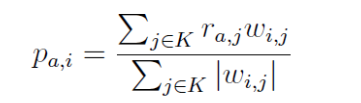

In [22]:
Image(filename='./images/item-based-similarity.png') 

In [23]:
predictor = ItemBasedPredictor(rm, cosine, n_neighbors)
predictor.evaluate(rm)

{'rmse': 1.815, 'mse': 3.295}

In [24]:
user_id = 4
item_id = 3

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 4.
- Item ID: 3.
- Predicted rating: 8.0.
- Real rating: 8 (0 == unrated item).


### Similar items (Adjusted cosine sim)

**AdjustedCosineSimilarityService** class finds k similar items given the item_id and ratings matrix.

In [25]:
user_id = 3 

sim_service = AdjustedCosineSimilarityService(rm, n_neighbors)

similarities, indices = sim_service.similars(item_id)

show_similar_items(indices, similarities, item_id)

4 most similar items to item 3:

- Item ID 1, with similarity of 0.42126273187113467.
- Item ID 6, with similarity of -0.05363989048891138.
- Item ID 5, with similarity of -0.2305213582693748.
- Item ID 4, with similarity of -0.7679410465751941.


### Item based prediction using adjusted cosine similarity

**AdjustedCosineItemBasedPredictor** class predicts the rating for specified user-item combination for adjusted cosine item-based approach. As the adjusted cosine similarities range from -1,+1, sometimes the predicted rating can be negative or greater than max value. Hack to deal with this: Rating is set to min if prediction is negative, Rating is set to max if prediction is above max.

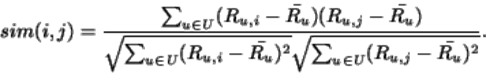

In [26]:
Image(filename='./images/adj-cos-sim.png')

In [27]:
predictor = AdjustedCosineItemBasedPredictor(rm, n_neighbors)
predictor.evaluate(rm)

{'rmse': 3.637, 'mse': 13.23}

In [28]:
user_id = 1
item_id = 1

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 1.
- Item ID: 1.
- Predicted rating: 4.0.
- Real rating: 3 (0 == unrated item).


## Predict and evaluate

In [29]:
user_id=1
item_id=5

predictors = PredictorFactory.create(rm, n_neighbors)

predict(predictors, user_id, item_id), rm.cell(user_id, item_id)

({'user_based_with_cosine': 9.0,
  'user_based_with_pearson': 8.0,
  'item_based_with_cosine': 7.0,
  'item_based_with_adj_cosine': 9.0,
  'item_based_with_pearson': 0},
 9)

if the item is already rated, it is not recommended:

In [30]:
user_id=2
item_id=1

predict(predictors, user_id, item_id), rm.cell(user_id, item_id)

({'user_based_with_cosine': 5.0,
  'user_based_with_pearson': 5.0,
  'item_based_with_cosine': 7.0,
  'item_based_with_adj_cosine': 4.0,
  'item_based_with_pearson': 5.0},
 7)

Evaluate predictions using RMSE and MAE error metrics:

In [31]:
evaluate(predictors, rm)

{'user_based_with_cosine': {'rmse': 1.701, 'mse': 2.892},
 'user_based_with_pearson': {'rmse': 1.367, 'mse': 1.868},
 'item_based_with_cosine': {'rmse': 1.815, 'mse': 3.295},
 'item_based_with_adj_cosine': {'rmse': 3.637, 'mse': 13.23},
 'item_based_with_pearson': {'rmse': 3.409, 'mse': 11.621}}

## Movie lens dataset

In [32]:
# ! wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# ! unzip ml-latest-small.zip

In [33]:
def most_common(df, column, limit):
    return df[column].value_counts()[:limit].index.tolist()

def preprocessing(df, n_users, n_movies):
    pd.options.mode.chained_assignment = None 
    most_common_users  = most_common(df, 'userId', n_users)
    most_common_movies = most_common(df, 'movieId', n_movies)
    df = df[df['userId'].isin(most_common_users) & df['movieId'].isin(most_common_movies)]

    df['user_seq']  = df.userId.apply(Sequence(1).apply)
    df['movie_seq'] = df.movieId.apply(Sequence(1).apply)

    return df.drop(columns=['userId', 'timestamp'])

In [34]:
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
ratings = preprocessing(ratings, n_users=200, n_movies=200)
ratings.rating.value_counts()

4.0    4955
5.0    3061
3.0    2565
3.5    2196
4.5    1895
2.0     759
2.5     610
1.0     233
1.5     131
0.5     103
Name: rating, dtype: int64

In [35]:
ratings.shape

(16508, 4)

In [63]:
rm = RatingsMatrix.from_df(ratings, ['user_seq', 'movie_seq', 'rating'])
rm.shape

(200, 200)

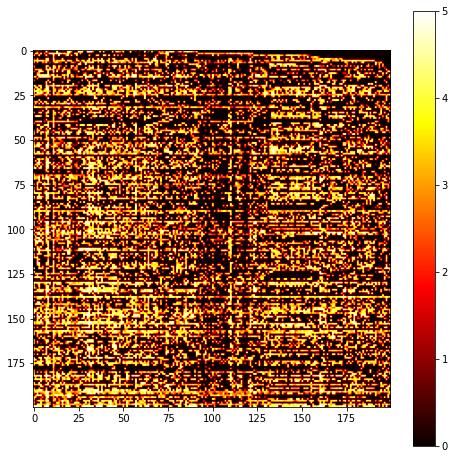

In [65]:
rm.plot((8, 8))

In [37]:
user_ids  = most_common(ratings, 'user_seq', 20)
movie_ids = most_common(ratings, 'movie_seq', 20)

user_id = user_ids[-1]
item_id = movie_ids[-1]

In [38]:
predictors = PredictorFactory.create(rm, n_neighbors=10)

In [39]:
predict(predictors, user_id, item_id), rm.cell(user_id, item_id)

({'user_based_with_cosine': 3.0,
  'user_based_with_pearson': 5.0,
  'item_based_with_cosine': 4.0,
  'item_based_with_adj_cosine': 4.0,
  'item_based_with_pearson': 4.0},
 3.5)

In [40]:
evaluate(predictors, rm)

{'user_based_with_cosine': {'rmse': 1.272, 'mse': 1.618},
 'user_based_with_pearson': {'rmse': 1.042, 'mse': 1.085},
 'item_based_with_cosine': {'rmse': 1.38, 'mse': 1.905},
 'item_based_with_adj_cosine': {'rmse': 0.785, 'mse': 0.616},
 'item_based_with_pearson': {'rmse': 1.604, 'mse': 2.573}}